In [1]:
%load_ext autoreload
%autoreload 2

%load_ext scalene

from Optimizer import *
from SlippageModel import average_slippage_model_vectorized, average_slippage_model_cvxpy

import pandas as pd
import numpy as np

import sys
import os

import optuna

# Absolute or relative path to your library
lib_path = os.path.abspath("/home/ubuntu/git/Baus-Research/")

# Add to sys.path
if lib_path not in sys.path:
    sys.path.append(lib_path)

from src.baus_utils.data_utils import get_tardis_files
from src.baus_utils.system_utils import log_message

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# In-Samples
#"2022-02-01"-"2022-06-01"
#"2022-11-01"-"2023-05-01"
#"2024-01-01"-"2024-06-01"

start_date = pd.Timestamp("2021-02-01")
start_date_hourly_returns = pd.Timestamp("2022-01-01")
end_date = pd.Timestamp("2022-07-01")

In [3]:
predicted_returns = pd.read_parquet("forecasts_v4.parquet").set_index("timestamp")
predicted_returns = predicted_returns.loc[start_date:end_date]

unique_coins = predicted_returns.TICKER.unique()

predicted_returns = predicted_returns.iloc[len(unique_coins):].fillna(0)
predicted_returns = predicted_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [4]:
resid_returns = pd.read_parquet("resid_returns_top50.parquet.gz").set_index("timestamp")
resid_returns = resid_returns.loc[start_date_hourly_returns:end_date]
resid_returns = resid_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER")).fillna(0)

In [5]:
factors = pd.read_parquet("risk_factor_loadings.parquet.gz").set_index("timestamp")
factors = factors.loc[start_date_hourly_returns:end_date].fillna(0)

exposure_columns = [column_name for column_name in factors.columns if "exposure" in column_name]
return_columns = [column_name for column_name in factors.columns if "returns" in column_name]

factor_exposures = factors[exposure_columns + ["TICKER"]].fillna(0)
factor_returns = factors[return_columns]
factor_returns = factor_returns.groupby(factor_returns.index).tail(1).fillna(0)

factor_exposures = factor_exposures.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [6]:
betas = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["beta_clip", "TICKER"]].fillna(0)
index_prices = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["index_price", "TICKER"]].fillna(0)

betas = betas.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))
index_prices = index_prices.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [7]:
coin_specs = {}
volumes = pd.DataFrame()
for coin in unique_coins:
    print(coin)
    temp_data = get_tardis_files(start_date_hourly_returns, end_date, 'trades', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                            normalize=True, allow_missing_dates=True, verbose=False)
    volumes[coin] = temp_data["volume"].rolling(24).sum() * temp_data["close"]
    price_str = str(temp_data["close"].iloc[-1])
    digits = len(price_str.split(".")[1])
    increment = round(0.1**digits, digits)
    coin_specs[coin] = (digits, increment)

volumes = volumes.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="volume").set_index("timestamp")

1000SHIB
AAVE
ADA
ALGO
ALICE
ATOM
AVAX
AXS
BAT
BCH
BNB
BTT
CELR
CHR
CRV
DOGE
DOT
DYDX
EGLD
ENJ
EOS
ETC
ETH
FIL
FTM
GALA
GTC
ICP
LINK
LRC
LTC
LUNA
MANA
MATIC
NEAR
ONE
SAND
SFP
SOL
SUSHI
TLM
UNI
VET
XLM
XRP
XTZ
YFI
ZEC
SXP
THETA
PEOPLE
ROSE
WAVES
KNC
RUNE
IMX
OGN
ZIL
CHZ
IOST
AUDIO
GRT
GMT
APE
MTL
TRX
ZRX
BAKE
XMR
LINA
KAVA
ENS
JASMY
DAR
BEL
GAL
RSR
UNFI
BLZ
FLM
LIT
SNX
STORJ
OP


In [8]:
volumes = volumes.fillna(0)

In [9]:
funding_rates = pd.DataFrame()
for coin in unique_coins:
    funding = get_tardis_files(start_date, end_date, 'derivative_ticker', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                            normalize=True, allow_missing_dates=True, verbose=False)
    funding.loc[funding.index != funding["funding_timestamp"], "funding_rate"] = 0
    funding = funding["funding_rate"]
    funding_rates[coin] = funding
funding_rates = funding_rates.fillna(0)
funding_rates = funding_rates.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="funding_rate").set_index("timestamp")

In [10]:
liquidity = pd.read_csv("LiquidityDataCombined.csv").set_index("date")[["TICKER", "spread"]]
liquidity.index = pd.to_datetime(liquidity.index)

In [11]:
recovery_rate = 2

mean_error_df = index_prices.copy()
mean_error_df["return"] = mean_error_df.groupby('TICKER')['index_price'].shift(-1) / index_prices['index_price'] - 1
mean_error_df = mean_error_df[["TICKER", "return"]]

mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                             np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                             np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)

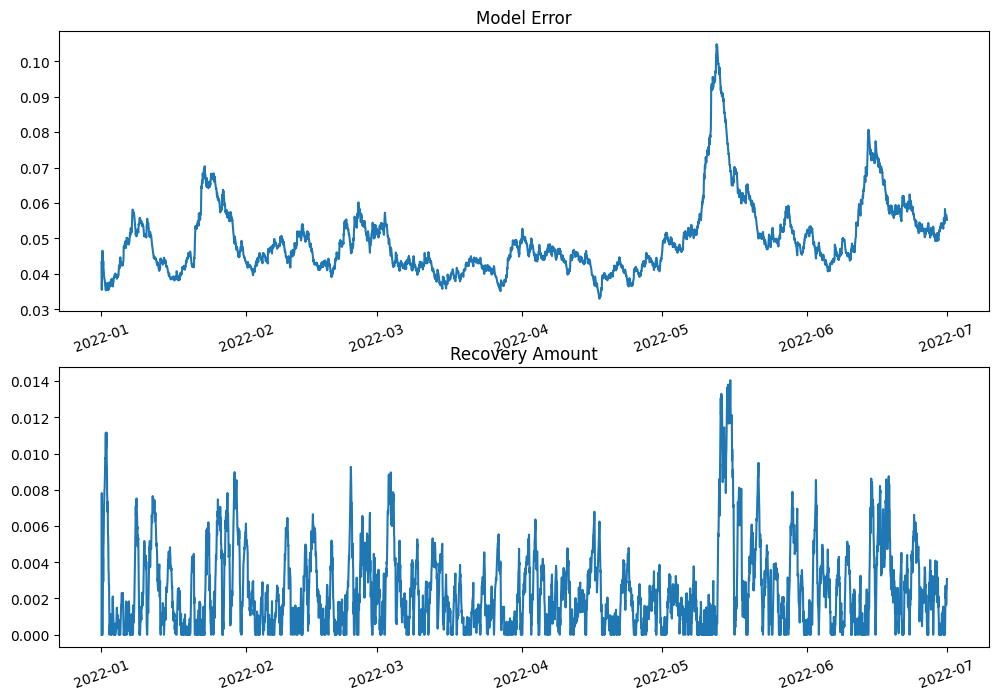

In [12]:
figs, axis = plt.subplots(2, figsize=(12,8))

axis[0].plot(absolute_mean_error)
axis[0].set_title("Model Error")
axis[0].tick_params(axis='x', rotation=20)

axis[1].plot(recovery_amt)
axis[1].set_title("Recovery Amount")
axis[1].tick_params(axis='x', rotation=20)

plt.show()

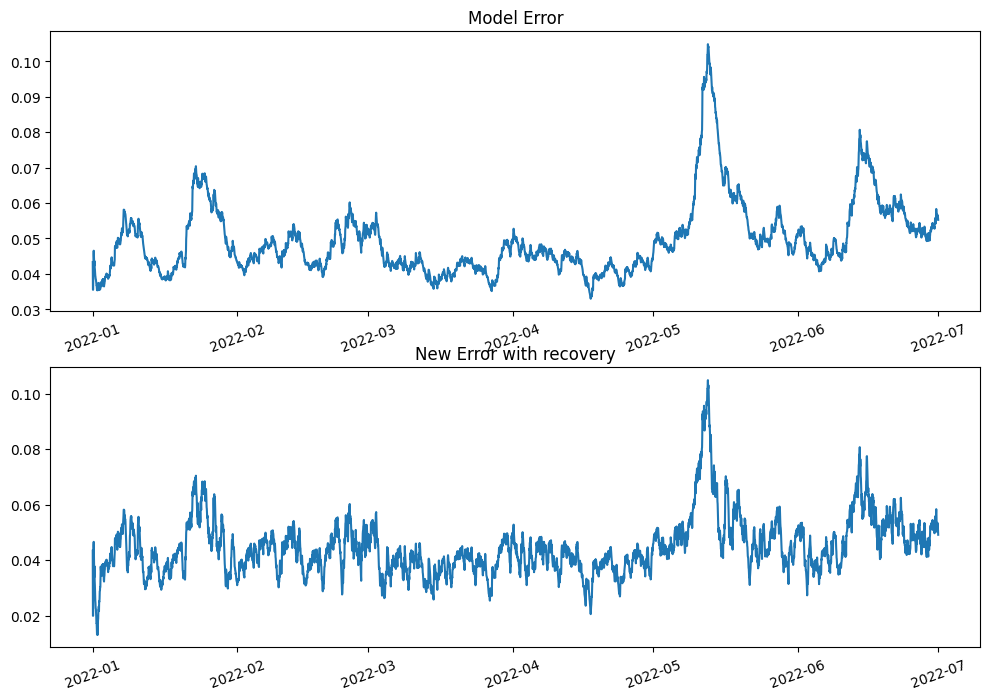

In [13]:
figs, axis = plt.subplots(2, figsize=(12,8))

axis[0].plot(absolute_mean_error)
axis[0].set_title("Model Error")
axis[0].tick_params(axis='x', rotation=20)

axis[1].plot(new_error)
axis[1].set_title("New Error with recovery")
axis[1].tick_params(axis='x', rotation=20)


plt.show()

In [12]:
import warnings
warnings.filterwarnings("ignore")

Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio 

/home/ubuntu/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-pack

2022-06-30 23:00:00


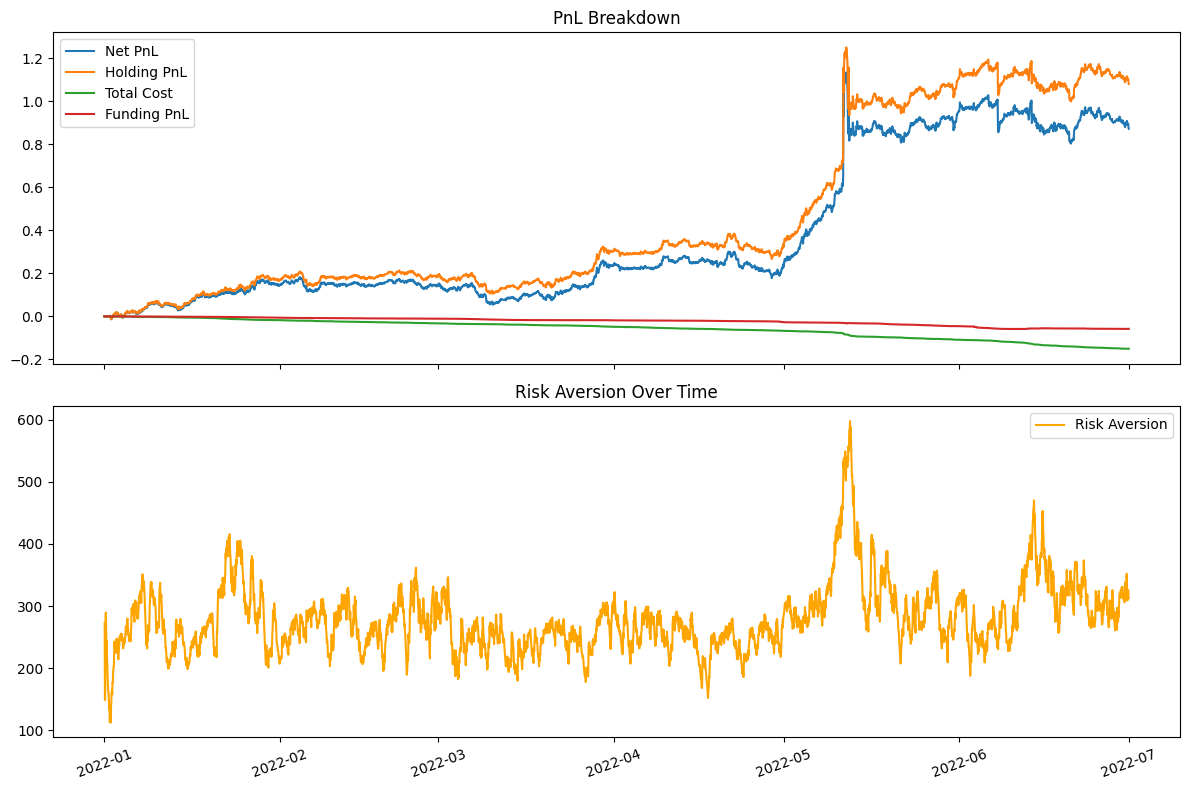

day_count                       181.000000
daily_ret_mean       (bps)       39.507011
daily_ret_std        (bps)      300.307973
daily_ret_skew       (bps)        6.059705
daily_ret_max        (bps)     3174.342880
daily_ret_min        (bps)    -1116.543983
annualized_ret       (bps)    26408.150522
monthly_geometic_ret (bps)     1136.957222
max_drawdown         (bps)    -1272.615603
annual_ret/max_drawdown          20.751082
sharpe                            2.513354
sortino                           4.798047
tot_compounded_ret   (bps)     8979.860379
rolling_1yr_vol_mean (bps)             NaN
rolling_1yr_vol_min  (bps)             NaN
rolling_1yr_vol_max  (bps)             NaN
daily_ret_10th       (bps)     -182.249914
daily_ret_25th       (bps)      -81.933648
daily_ret_50th       (bps)       21.664295
daily_ret_75th       (bps)      138.208821
daily_ret_90th       (bps)      206.114027
dtype: float64
Backtest Complete!


In [23]:
max_holding = 0.1         
volume_max_turnover = 0.01
min_yearly_return = 0.3   
min_portfolio_change = 0.325
taker_fees = 0.00035    

lambda_0 = 43.33
alpha = 5293

sharpes = []

# with slippage
optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_portfolio_change, min_yearly_return, taker_fees, True, 5, 24)
%scrun sharpe, calmar, final_equity = optimizer.backtest(1000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, True, liquidity)

# without slippage
#optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_yearly_return, taker_fees, False, 5)
#sharpe, calmar, final_equity = optimizer.backtest(10000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, True)

In [ ]:
max_holding = 0.1
volume_max_turnover = 0.01
min_yearly_return = 0.3   
taker_fees = 0.00035

# Bayesian Hyperparameter tuning
def objective(trial):
    recovery_rate = trial.suggest_float('recovery_rate', 0, 2)
    lambda_0 = trial.suggest_float('lambda_0', 0, 50)
    alpha = trial.suggest_float('alpha', 0, 10000)
    sparsity_penalty = trial.suggest_float('sparsity_penalty', 0, 0.1)
    min_portfolio_change = trial.suggest_float('min_portfolio_change', 0, 0.4)

    mean_error_df = index_prices.copy()
    mean_error_df["return"] = mean_error_df.groupby('TICKER')['index_price'].shift(-1) / index_prices['index_price'] - 1
    mean_error_df = mean_error_df[["TICKER", "return"]]

    mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
    mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                                np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                                np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

    absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
    recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
    recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

    new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)


    # with slippage
    optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, sparsity_penalty, min_portfolio_change, min_yearly_return, taker_fees, True, 5, 24)
    sharpe, calmar, final_equity = optimizer.backtest(1000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, False, liquidity)

    # without slippage
    #optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, sparsity_penalty, min_portfolio_change, min_yearly_return, taker_fees, False, 5)
    #sharpe, calmar, final_equity = optimizer.backtest(10000000, predicted_returns, betas, index_prices, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, False)

    return 0.4 * sharpe/3 + 0.6*calmar/6


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study. best_trial.value)

[I 2025-08-01 16:53:52,925] A new study created in memory with name: no-name-786c4c3d-82cc-4a90-ab44-0fb76fb513e2


Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio 

[I 2025-08-01 16:57:58,125] Trial 0 finished with value: 5.329130915372599 and parameters: {'recovery_rate': 1.2783798886673596, 'lambda_0': 48.80792832122714, 'alpha': 7914.694362952, 'sparsity_penalty': 0.09154996984719592, 'min_portfolio_change': 0.15464868179307223}. Best is trial 0 with value: 5.329130915372599.


Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio 

[I 2025-08-01 17:01:49,621] Trial 1 finished with value: 4.8839668774383735 and parameters: {'recovery_rate': 0.0680630726575393, 'lambda_0': 1.5160446216071155, 'alpha': 4164.074351265033, 'sparsity_penalty': 0.004705230298818886, 'min_portfolio_change': 0.1144383637853736}. Best is trial 0 with value: 5.329130915372599.


Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio 

[I 2025-08-01 17:05:31,849] Trial 2 finished with value: 2.8764267215377712 and parameters: {'recovery_rate': 1.134694330619888, 'lambda_0': 22.19931493842666, 'alpha': 6318.326568021246, 'sparsity_penalty': 0.0005012821496462316, 'min_portfolio_change': 0.21631659824655936}. Best is trial 0 with value: 5.329130915372599.


Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio unchanged.
Optimizer Status: infeasible
Solution not optimal! Keeping portfolio 

In [24]:
# Continue Optimization
study.optimize(objective, n_trials=50)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study. best_trial.value)

NameError: name 'study' is not defined

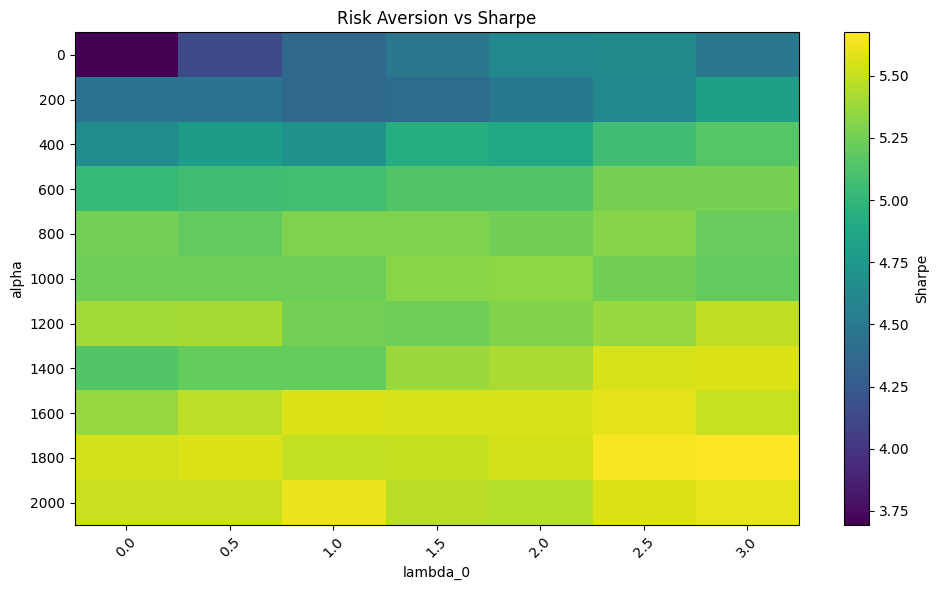

In [141]:
lambda_vals = np.arange(0, 3.5, 0.5)  
alpha_vals = np.arange(0, 2200, 200)

a = np.array(lambdas[:-30])
b = np.array(alphas[:-30])
c = np.array(sharpes[:-30])

c_matrix = np.array(c).reshape(len(lambda_vals), len(alpha_vals)).T

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(c_matrix, cmap='viridis', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(lambda_vals)))
ax.set_yticks(np.arange(len(alpha_vals)))
ax.set_xticklabels(np.round(lambda_vals, 2))
ax.set_yticklabels(alpha_vals)
ax.set_xlabel('lambda_0')
ax.set_ylabel('alpha')
ax.set_title('Risk Aversion vs Sharpe')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Sharpe')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()